In [12]:
### imports
import numpy as np
import pandas as pd
import ast
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import clone

import sys

sys.path.append("..")
sys.path.append("../src")

from src.datahandling.loading import load_data  # loading
import src.datahandling.visualization as vis  # plotting
from src.models.ma import MovingAverage  # model
from src.datahandling.preprocessing import (
    DataCleaner,
    SupervisedTransformer,
    train_test_split,
)  # preprocessing

### load benchmarks
benchmarks = pd.read_csv("../results/benchmarks.csv")

# Model: Moving Average

The _Moving Average_ model, the most basic model within this project, operates on the principle that the value of the next time step is computed as the average of the preceding $n$ values. In future we also refer to $n$ as _"window size"_. Furthermore, the model is expanded by incorporating a discount factor $\gamma \in (0,1]$, which assigns varying weights to these values. Consequently, it closely resembles the concept of discounting employed in determining future rewards within reinforcement learning. The formula for the _Moving Average_ model is expressed as follows:

$$\hat{y}_ {t+1} = \tfrac{1}{n} \sum_ {i=0}^{n-1} \gamma^i \cdot y_ {t-i}$$

Note that by setting $n = 1$ the model reduces to a very naive model that simply predicts the value of the current time step. This can be seen as the most simplistic approach to the problem and will be therefore be referred to as baseline model.
Both, $n$ and $\gamma$ are hyperparamaters that will be tuned for each dataset individually in the following sections.

The model is implemented in the file `src/models/ma.py`. 


In [13]:
### Define the model
model = Pipeline(
    [
        ("st", SupervisedTransformer()),
        ("ma", MovingAverage()),
    ]
)

In [14]:
### Define the hyperparameter grid
param_grid = {
    "st__horizon": ["10min", "hourly", "daily"],  # different tasks
    "st__window_size": [1, 5, 10, 100, 200],
    "ma__discount": np.round(np.linspace(0.5, 1, 6), 2),
}

## British Dataset - Kelmarsh

For a description and analysis of the dataset, please refer to the notebook `DataInspection.ipynb`. 

The dataset is loaded and cleaned in the following cell. As the _Moving Average_ model only relies on past values of the target variable and not on any other features, we only need to load the target variable _Power (kW)_. The SupervisedTransformer is then used to transform the most recent #window size values into a dataframe.

In [15]:
### loading data
TURBINE_ID = 2
data_british = load_data(turbine_id=TURBINE_ID, which_data="British")

### cleaning data
cleaner = DataCleaner(features=["Power (kW)"], rename_features=["power"])
data_british = cleaner.transform(data_british)

### create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][0]
test_end = benchmarks["test_end"][0]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_british, test_start=test_start, test_end=test_end, target_var="power"
)

In [16]:
### hyperparameter tuning
### RUNTIME: ~6 min on my machine
do_gridsearch = False

if do_gridsearch:

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=5),
        verbose=1,
        refit=False,
    )

    grid_search.fit(X_train, y_train)
    res_gs_brit = pd.DataFrame(grid_search.cv_results_)
    ### store results in csv-file
    pd.DataFrame(res_gs_brit).to_csv("../results/results_gs_ma_brit.csv")
    ### reload results is often necessary because of the data type
    res_gs_brit = pd.read_csv("../results/results_gs_ma_brit.csv")
else:
    res_gs_brit = pd.read_csv("../results/results_gs_ma_brit.csv")

Let's have a look at the results of the performed gridsearch.

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


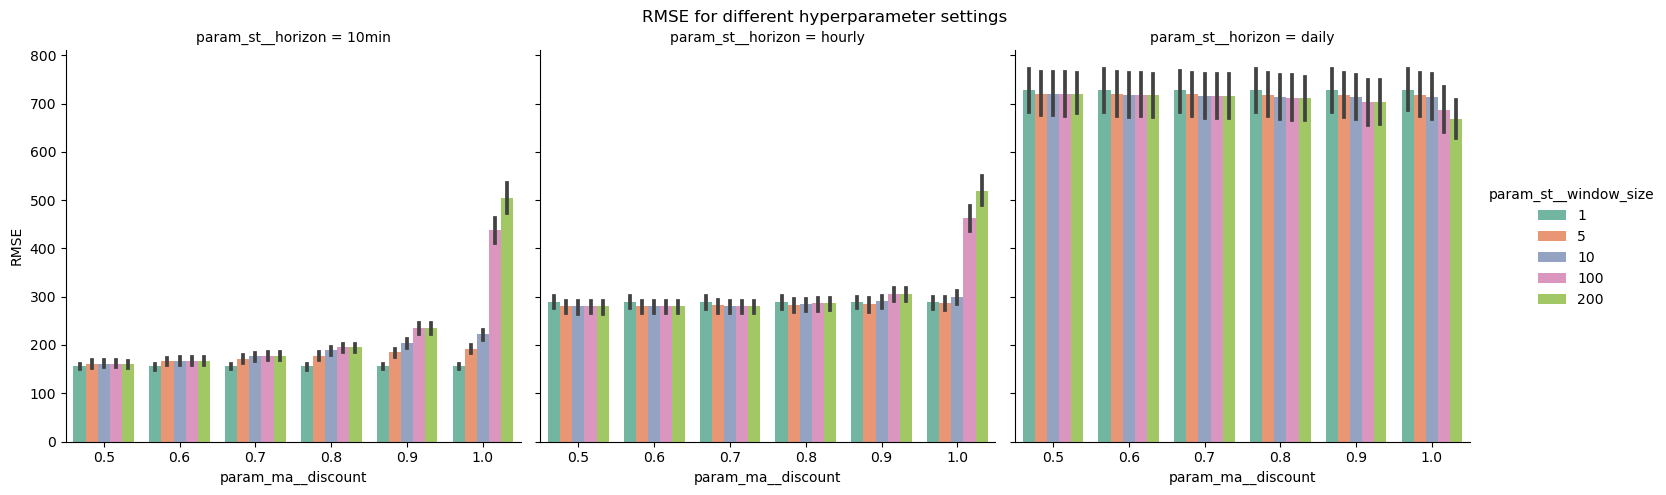

In [17]:
vis.plot_gridsearch_results(
    res_gs_brit, x="param_ma__discount", hue="param_st__window_size", 
)

__Analysis:__ 

The baseline model (window size = 1) performs best on predicting the next time step in the series (horizon = 10 min, left subplot). 
As the discount factor $\gamma$ increases, the negative impact on the window size becomes stronger. This correlation is logical because the discount factor is employed to assign greater importance to past values. When the discount factor is elevated, historical values are given even more significance. This aligns with our intuitive understanding, as the power output from the previous day should not excessively affect predictions for the subsequent ten minutes.

If we look on the performances for predicting the power output in one hour (middle subplot), it is evident that models with window sizes greater than one consistently outperform the baseline model across all discount factors. Interestingly, when the discount factor is set to 1.0, the model with a window size of 5 shows the highest performance. This window size aligns best of all options with the time span we aim to predict into the future. Nonetheless, when evaluating performance across all discount factors, we observe multiple candidate models that exhibit equally results. From the plot we cannot infer which model exactly has the lowest mean test error.

When we look at the performance for predicting the power output in one day (right subplot), we observe a reverse correlation as in the left subplot. The largest window size, 200, consistently outperforms the baseline model across all discount factors, with the baseline model performing the poorest. Between these extremes, we notice a negative correlation. 

Overall, this analysis suggests the following __hypothesis__ about the window size: 

__The optimal value of the window size should be in the same order of magnitude as the time span we aim to predict into the future.__

In [18]:
### extract best parameters of each model for each horizon
best_params_brit_ma = (
    res_gs_brit.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_brit_ma.index:
    print(
        f"Best parameters for horizon {horizon}: {best_params_brit_ma.loc[horizon][0]}"
    )

Best parameters for horizon 10min: {'ma__discount': 0.5, 'st__horizon': '10min', 'st__window_size': 1}
Best parameters for horizon daily: {'ma__discount': 1.0, 'st__horizon': 'daily', 'st__window_size': 200}
Best parameters for horizon hourly: {'ma__discount': 0.6, 'st__horizon': 'hourly', 'st__window_size': 100}


__Remark to the optimal parameters of the hourly prediction:__

The optimal window size of 100 seem to contradict the hypothesis developed above. However, we need to take the rather small discount factor of 0.6 into account. For values that lie more than one our in the past, this means that they weighed with a factor of $0.6^{7} \approx 0.03$ or less. Compared to the initial weigths of $0.6^{0} = 1.0$ and $0.6^{1} = 0.6$, this is a very small value. Consequently, the model with a window size of 100 is very similar to a model with a smaller window size when using a discount factor of 0.6.

In [19]:
### create models and refit them with best parameters,
#   then predict on test set
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_brit_ma.loc[horizon][0])
    )
    models[horizon].fit(X_train, y_train)
    predictions[horizon] = models[horizon].predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

The predictions of the optimal model for the different forecasting horizons are plotted in the following cell. To ensure visibility of the predictions, we only plot the first 3000 values of the test set.

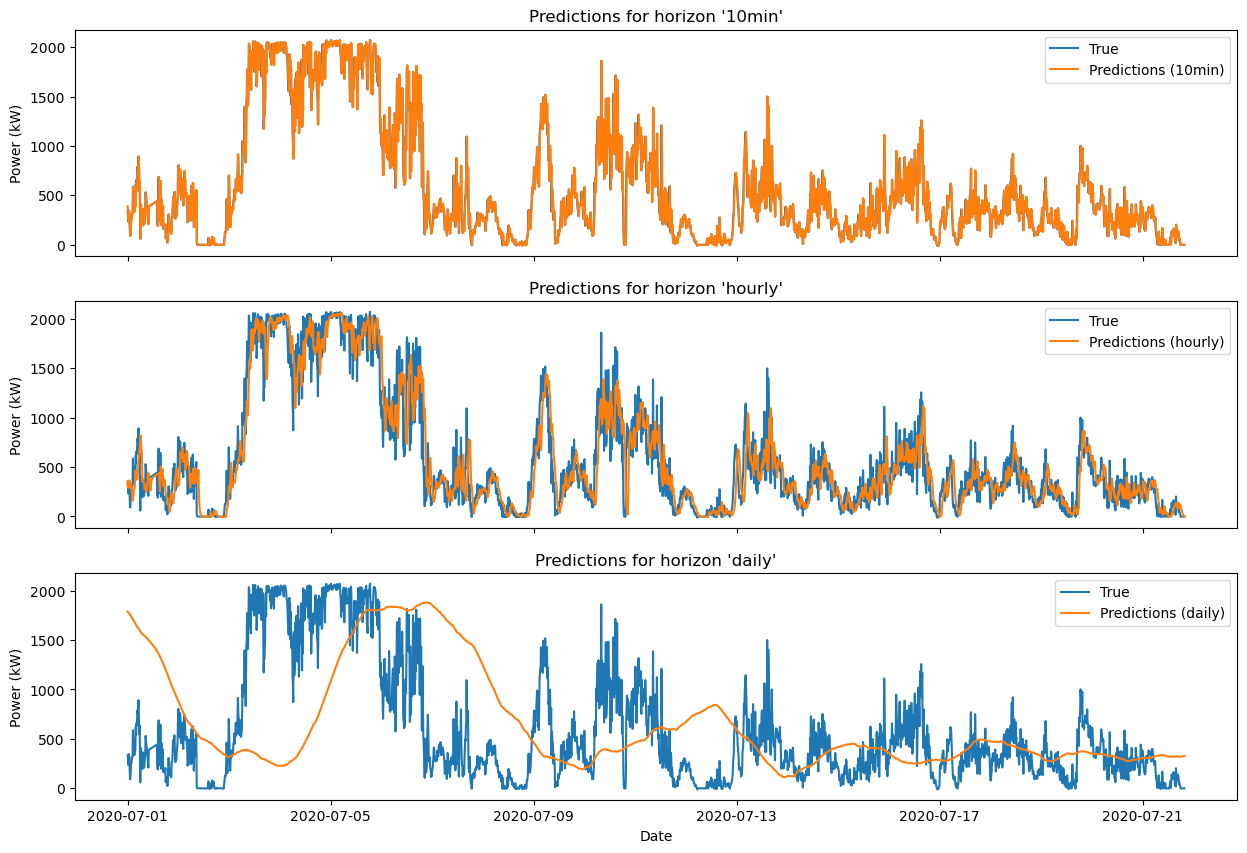

In [20]:
### plot first 3000 predictions
vis.plot_predictions(predictions.iloc[:3000], y_test.iloc[:3000])

__Analysis:__ 

When looking at the predictions of the optimal models for the different forecasting horizons, we observe the following:

- Since the optimal model for the 10 min horizon is the baseline model, the predictions are simply the values of the previous time step. So we achieve the exact same curve as the original time series but shifted by one time step.

- The ideal model for the 1-hour forecast horizon generally approximates the actual data accurately, although it occasionally struggles to replicate the extreme, sudden spikes, and deep troughs seen in the actual data. Moreover, we notice a rightward shift in the predictions, which is anticipated since the model is trained using historical values of the target variable.

- Predicting the power output for a full day yields only partial success. The model can capture the overall data trend, resulting in a smooth curve, but struggles to replicate the properties of underlying ground truth data. This model is better suited for providing a rough estimate of the power output rather than making detailed, fine-grained predictions.

## Brazilian Dataset - Beberine

We follow the exact same procedure as for the British dataset.

In [21]:
### loading data
TURBINE_ID = 1  # Turbine 1 has a benchmark loss
data_braz = load_data(turbine_id=TURBINE_ID, which_data="Brazilian")

### cleaning data
cleaner = DataCleaner(features=["active_power_total"], rename_features=["power"])
data_braz = cleaner.transform(data_braz)

### create train and test set (exactly as used in the benchmarks)
test_start = benchmarks["test_start"][3]
test_end = benchmarks["test_end"][3]
X_train, y_train, X_test, y_test = train_test_split(
    df=data_braz, test_start=test_start, test_end=test_end, target_var="power"
)

In [22]:
### hyperparameter tuning
### RUNTIME: ~ 2 min on my machine
do_gridsearch = False

if do_gridsearch:

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=TimeSeriesSplit(n_splits=5),
        verbose=1,
        refit=False,
    )
    grid_search.fit(X_train, y_train)
    res_gs_braz = pd.DataFrame(grid_search.cv_results_)
    # store results in csv-file
    pd.DataFrame(res_gs_braz).to_csv("../results/results_gs_ma_braz.csv")
else:
    # load results
    res_gs_braz = pd.read_csv("../results/results_gs_ma_braz.csv")

/Users/haraldkugler/miniconda3/envs/res_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


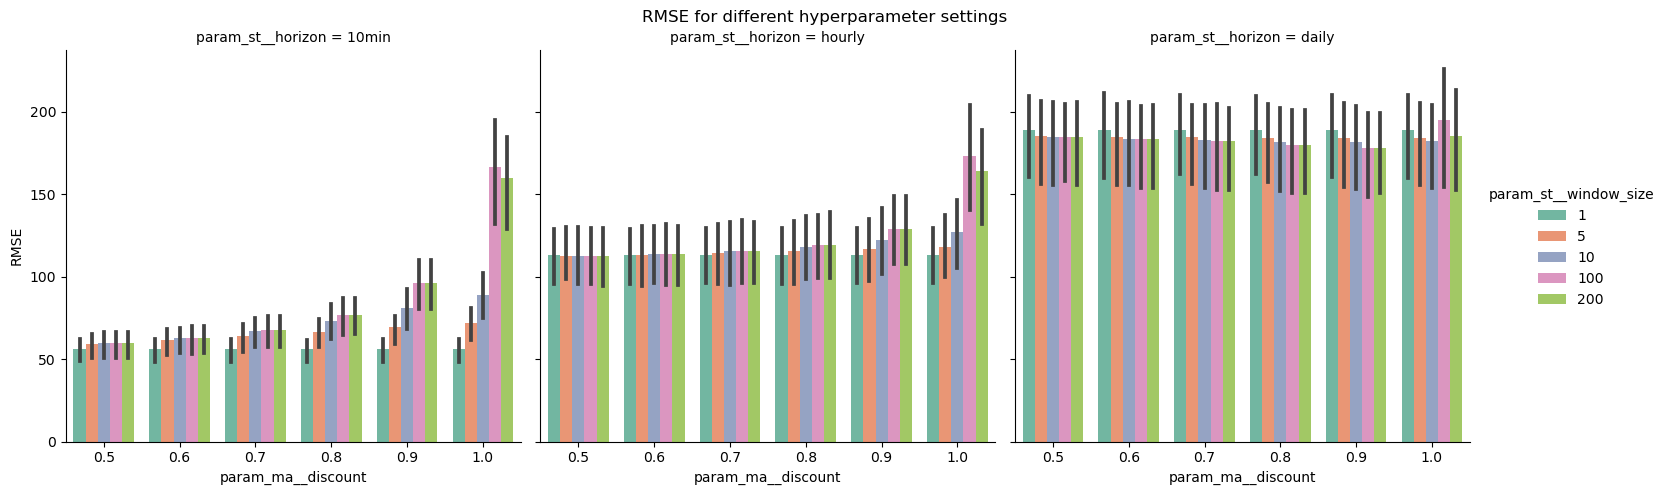

In [23]:
vis.plot_gridsearch_results(
    res_gs_braz, x="param_ma__discount", hue="param_st__window_size",
)

__Analysis:__

The results of all three prediction horizon resemble the ones from the British dataset. The optimal window size is in the same order of magnitude as the time span we aim to predict into the future. Note that we observe a higher variances across the folds. This is likely due to the fact that the dataset is much smaller than the British dataset.

In [24]:
### extract best parameters of each model for each horizon
best_params_braz_ma = (
    res_gs_braz.set_index(["params"])[["mean_test_score", "param_st__horizon"]]
    .groupby("param_st__horizon")
    .idxmax()
)

# print best parameters for each horizon
for horizon in best_params_braz_ma.index:
    print(
        f"Best parameters for horizon {horizon}: {best_params_braz_ma.loc[horizon][0]}"
    )

Best parameters for horizon 10min: {'ma__discount': 0.5, 'st__horizon': '10min', 'st__window_size': 1}
Best parameters for horizon daily: {'ma__discount': 0.9, 'st__horizon': 'daily', 'st__window_size': 200}
Best parameters for horizon hourly: {'ma__discount': 0.5, 'st__horizon': 'hourly', 'st__window_size': 5}


In [25]:
### create models and refit them with best parameters,
#   then predict on test set
models = {}
predictions = {}
for horizon in ["10min", "hourly", "daily"]:
    models[horizon] = clone(model).set_params(
        **ast.literal_eval(best_params_braz_ma.loc[horizon][0])
    )
    models[horizon].fit(X_train, y_train)
    predictions[horizon] = models[horizon].predict(X_test)
predictions = pd.DataFrame(predictions, index=X_test.index)

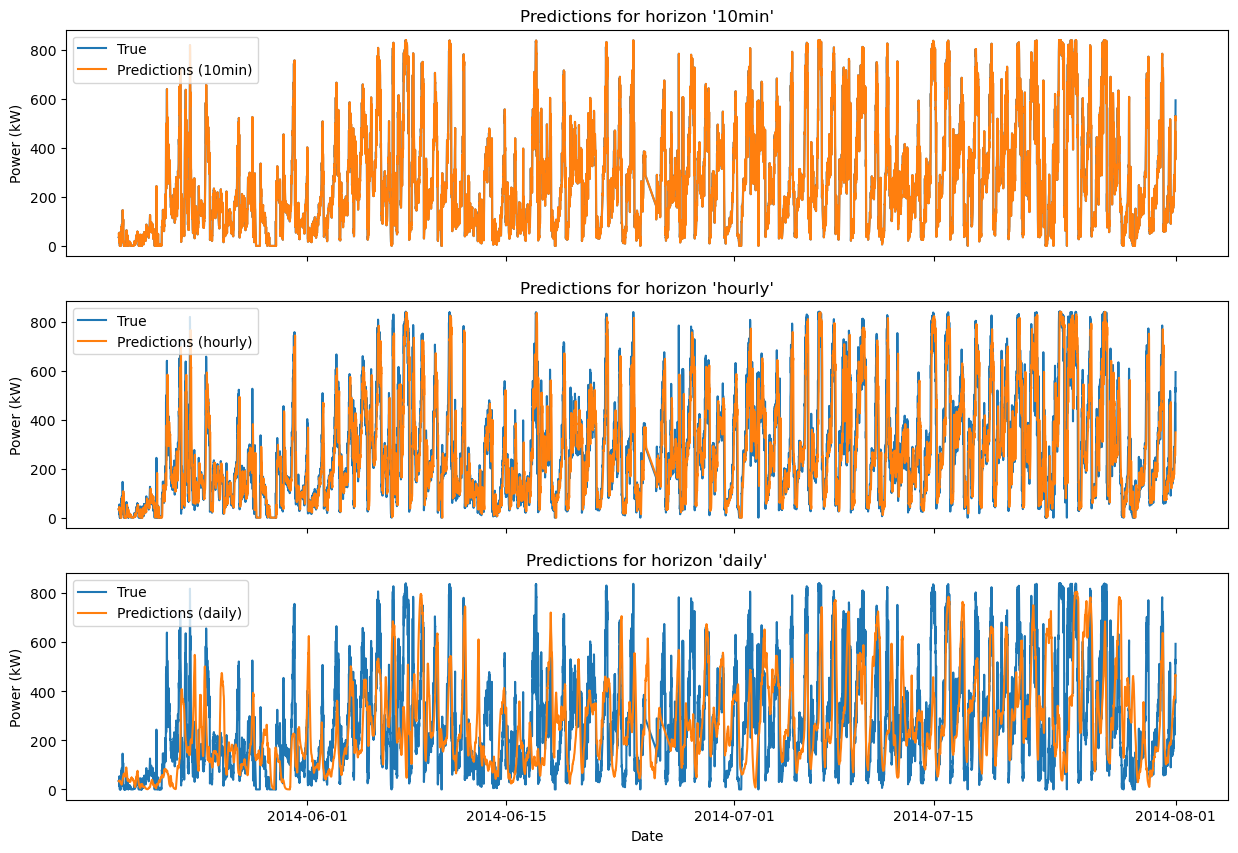

In [26]:
### plot predictions
vis.plot_predictions(predictions, y_test)

__Analysis:__

Again, we find very similar structures as in the British dataset. We therefore refer to the analysis above.

## Transfer Learning Approach

Since there is not really the need for fitting the model, i.e. no parameters have to be learned, this model can be seen as already fulfilling the transfer learning challenge because of its simplicity. 

## Summary

The _Moving Average_ model is a very simplistic approach that also comes along with cheap computationally costs. Nevertheless, it provides reasonably good predictions. A key take-away from this notebook is when transforming time series data into a supervised learning problem, the window size should be in the same order of magnitude as the time span we aim to predict into the future.
Additionally, the _Moving Average_ model solves the transfer learning challenge inherently because it does not need to be fitted.